In [20]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, halfnorm
%matplotlib inline

In [21]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [22]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [23]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [24]:
m_true = 0.0
b_true = .5

lnyerr_true = -2.3
lnV_true = -1.6

In [25]:
def lnlike(theta, x, y):
    m, b, lnyerr, lnV = theta
    #print(m, b, lnyerr, lnV)
    delty1 = 0
    delty2 = 0.3
    sigsq1 = .01
    sigsq2 = .04
    a1 = .5
    a2 = .5
    angle = np.arctan(m)
    delt1 = -np.sin(angle)*x + np.cos(angle)*(y-delty1) - b*np.cos(angle)
    delt2 = -np.sin(angle)*x + np.cos(angle)*(y-delty2) - b*np.cos(angle)
    #sigsq = (np.exp(lnyerr)*y)**2 * np.cos(angle)**2
    sigsq = a1*sigsq1 + a2*sigsq2
    return -np.sum(0.5*np.log(sigsq + np.exp(lnV))) - \
            np.sum(0.5*(delt1**2)/(sigsq + np.exp(lnV))) - np.sum(0.5*(delt2**2)/(sigsq + np.exp(lnV)))

In [26]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, lnyerr_true, lnV_true], args=(days, planets_etamb))
m_ml, b_ml, lnyerr_ml, lnV_ml= result["x"]

In [27]:
print(m_ml, b_ml, lnyerr_ml, lnV_ml)
print(np.exp(lnyerr_ml), np.exp(lnV_ml))

1.98429281197e-06 0.384748260505 -2.3 3.68372004513
0.100258843723 39.7941551164


In [28]:
def lnprior(theta):
    m, b, lnyerr, lnV= theta
    if 0.0 < b < 1.0:
#   if -1.0 < m < 1.0 and 0.0 < b < 1.0 and -5.0 < lnyerr < 0.0 and -3.0 < lnV < 0.0:
        pri_m = norm.logpdf(m, 0.0, 1.0)
        pri_lnyerr = norm.logpdf(lnyerr, -2.5, 2.5/3.0)
        pri_lnV = halfnorm.logpdf(np.sqrt(np.exp(lnV)), 0, .1)
        return pri_m + pri_lnyerr + pri_lnV
    return -np.inf

In [29]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [30]:
ndim, nwalkers = 4, 200
# pos = [result["x"] + np.random.randn(ndim)*1e-4*[.2, .1, .5, .3, .3] for i in range(nwalkers)] #nwalkers x ndim entries
pos = [np.random.randn(ndim)*1e-4*[0.001, .6, -2.5, -2.5] for i in range(nwalkers)]

In [31]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb), threads=4, a=2.0)

In [32]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[ -2.68936103e-06,   3.57583091e-01,  -1.62202976e+00,
          -4.66096347e-01],
        [  1.12125424e-05,   3.64363811e-01,  -2.85858091e+00,
          -2.21100316e-01],
        [  3.64775630e-05,   3.16605875e-01,  -2.07789048e+00,
          -4.83684138e-01],
        [  1.54663557e-05,   3.89143522e-01,  -7.79466929e-01,
          -6.54932775e-01],
        [  1.40416132e-05,   3.88411098e-01,  -3.12144296e+00,
          -6.01416965e-01],
        [ -1.18580496e-05,   4.21925879e-01,  -3.23267954e+00,
          -4.60884935e-01],
        [  2.44802430e-05,   3.38148273e-01,  -2.60277819e+00,
          -1.39131811e-01],
        [  1.92473595e-05,   3.37347539e-01,  -1.93151986e+00,
          -3.82630604e-01],
        [  4.33773822e-06,   3.68517846e-01,  -4.16306716e+00,
          -5.63036275e-01],
        [ -2.69319562e-05,   4.30741247e-01,  -2.56121426e+00,
          -3.11288948e-01],
        [  9.98516871e-06,   3.87458463e-01,  -2.70188511e+00,
          -7.16439975e-01],

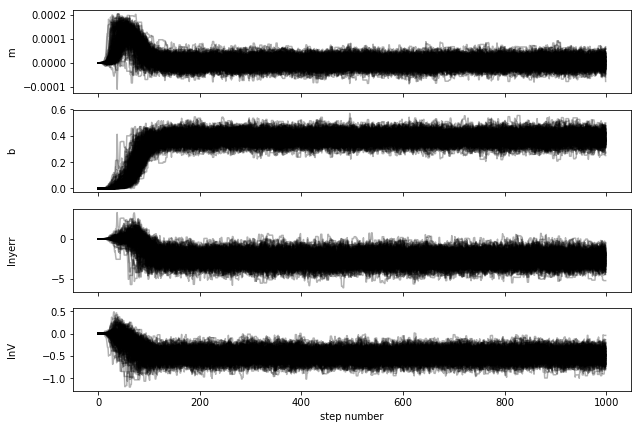

In [33]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["m", "b", "lnyerr", "lnV"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
    #(nwalkers, nsteps, dim)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss.png")
plt.show()

In [ ]:
flat_samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

In [ ]:
fig = corner.corner(flat_samples, labels=["$m$", "$b$", "$lnyerr$", "$lnV$"],
                      truths=[m_true, b_true, lnyerr_true, lnV_true])
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_corner.png")

In [ ]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
print(np.exp(-2.5))
print(np.exp(-.5))